# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [213]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 30
ROUNDS = 30
OTHER_DATE = '2021-11-11'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


# Initialize stim circuit

In [214]:
# AFTER_CLIFFORD_DEPOLARIZATION = 0.8e-3
# AFTER_RESET_FLIP_PROBABILITY = 0.1e-2
# BEFORE_MEASURE_FLIP_PROBABILITY = 0.5e-2 
# BEFORE_ROUND_DATA_DEPOLARIZATION = 0.8e-2

AFTER_CLIFFORD_DEPOLARIZATION = 3e-2
AFTER_RESET_FLIP_PROBABILITY = 0.8e-2
BEFORE_MEASURE_FLIP_PROBABILITY = 1e-2 
BEFORE_ROUND_DATA_DEPOLARIZATION = 3e-2

SHOTS = int(1e3)

In [215]:
import stim
stim_circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=AFTER_CLIFFORD_DEPOLARIZATION, #two-qubit-fidelity,
                                after_reset_flip_probability=AFTER_RESET_FLIP_PROBABILITY, #reset error,
                                before_measure_flip_probability=BEFORE_MEASURE_FLIP_PROBABILITY, #measurement error,
                                before_round_data_depolarization=BEFORE_ROUND_DATA_DEPOLARIZATION) #idle error)



meas_outcomes = stim_circuit.compile_sampler().sample(SHOTS)
counts = {}
for row in meas_outcomes:
    count_str = ''
    for nb, bit in enumerate(row):
        count_str += '0' if bit == False else '1'
        if (nb+1) % (DISTANCE-1) == 0 and nb < ROUNDS*(DISTANCE-1):
            count_str += ' ' 
    
    count_str = count_str[::-1]
    if count_str in counts:
        counts[count_str] += 1
    else:
        counts[count_str] = 1


In [216]:
P_AMBIG = 0.1

iq_dict = simulator.generate_IQ_dict()
extreme_IQ_data = simulator.counts_to_IQ_extreme(P_AMBIG, iq_dict, counts)

100%|██████████| 1000/1000 [00:06<00:00, 166.25it/s]


# Get counts from IQ data

In [217]:
import cpp_soft_info

print(cpp_soft_info.get_counts(extreme_IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))

{'000000000010010001001110101100 00110000010111001100101111010 10001001011111001100100101010 10011101111111001100100001010 10011100010111001100111001011 00011100111011001100110101010 00000110111011100001110001011 00010011100011101000100110010 10000011100111010100010001010 10010000010011000000000001000 11110011000011000010100001110 10110001000011000100000001010 00010000000111000010010000010 10110000000011000000100010110 00110111000011100000010011110 00111110100011001000010010101 00111011010011000000000011101 00101010000111000100000011111 00101011100011000111000011100 01001010010011000110000011101 00001001001011000010001010001 00101001010000010110000010101 00001011000010000110000010100 01010011010000000110000001100 00110010000001000111000000100 00010010001100000100001100100 00100000110000000111001100000 00000100000000000100001100000 00101100000000000110100000100 00101100010000001000100000001 00111000100000000000100000000': 1, '000000000011110001010001001110 00000000010001001111001111001 

# Decode IQ data

In [218]:
import pymatching
import stim


model = stim_circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

P_MEAS = P_AMBIG

In [238]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=False, _bimodal=True, merge_strategy = "replace", _detailed=True, p_offset = 1)
print("num_errors:", result.num_errors, "out of", len(extreme_IQ_data), "shots")

num_errors: 413 out of 1000 shots


In [220]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(extreme_IQ_data), "shots")


num_errors: 512 out of 1000 shots


In [239]:
matching = pymatching.Matching.from_detector_error_model(model)

p_meas = -1
p_meas = 50e-2

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(extreme_IQ_data), "shots")
         
# takes 1s

num_errors: 411 out of 1000 shots


# Plot the results

In [222]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [0, 1, 2, 3, 4, 8, 10, 11, 13, 14, 15, 18, 19, 20, 23, 30, 31, 34, 37, 41, 43, 44, 45, 47, 50, 51, 52, 55, 59, 60, 61, 62, 66, 68, 71, 75, 77, 78, 80, 81, 85, 86, 87, 91, 95, 97, 101, 102, 105, 106, 107, 109, 112, 114, 118, 119, 120, 121, 127, 131, 134, 135, 139, 142, 143, 144, 145, 146, 147, 151, 153, 154, 159, 160, 161, 163, 165, 166, 169, 176, 180, 181, 182, 184, 185, 187, 188, 190, 194, 196, 197, 198, 199, 203, 204, 208, 212, 218, 221, 223, 225, 228, 230, 231, 233, 234, 235, 236, 239, 242, 244, 247, 250, 252, 253, 255, 257, 264, 268, 271, 273, 274, 275, 276, 277, 279, 280, 284, 294, 296, 301, 302, 304, 307, 313, 314, 315, 319, 320, 325, 326, 327, 330, 332, 333, 334, 335, 340, 341, 344, 345, 346, 347, 349, 355, 356, 357, 358, 359, 361, 366, 369, 372, 375, 378, 379, 380, 382, 385, 387, 389, 390, 396, 398, 404, 406, 410, 414, 416, 417, 418, 420, 425, 428, 430, 431, 435, 436, 437, 438, 439, 443, 444, 446, 449, 455, 457, 465, 466, 468, 471, 474, 477, 480, 487, 488, 490, 492, 494, 4

-----IQ-----


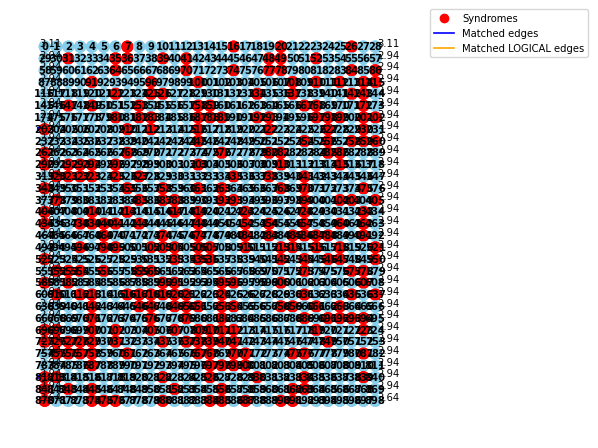

-----flat-----


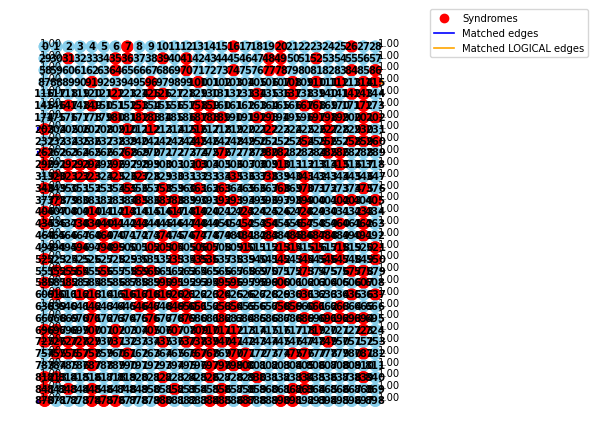

-----INFORMED-----


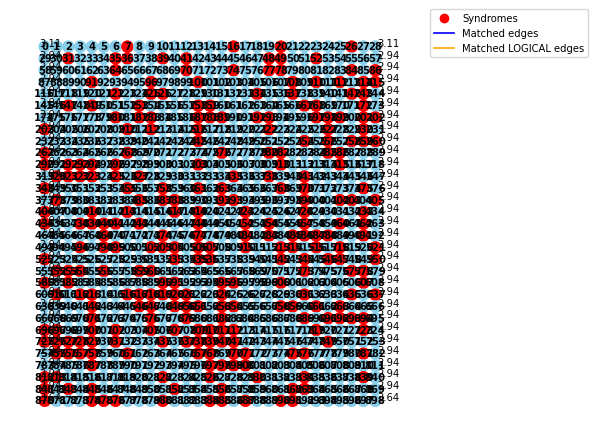

In [223]:
from soft_info import draw_matching_graph


index = 3

fig_size = (4, 13)
scale_factor = 0.6

to_be_result = result
details = to_be_result.error_details[index]
print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print("-----flat-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print("-----INFORMED-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [224]:
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print("indices that are in informed but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print("indices that are in IQ but not in informed with len:", len(iq_not_in_informed))
print(iq_not_in_informed)

print()

iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print("indices that are in IQ but not in flat with len:", len(iq_not_in_flat))
print(iq_not_in_flat)
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print("indices that are in flat but not in IQ with len:", len(flat_not_in_iq))
print(flat_not_in_iq)

indices that are in informed but not in IQ with len: 89
[7, 24, 29, 32, 35, 40, 72, 83, 92, 137, 157, 171, 175, 186, 200, 226, 227, 232, 238, 246, 259, 282, 291, 293, 306, 323, 331, 337, 339, 350, 365, 376, 377, 391, 392, 395, 397, 409, 411, 421, 427, 453, 463, 493, 496, 507, 515, 533, 541, 545, 546, 579, 596, 602, 650, 659, 671, 683, 720, 727, 730, 732, 745, 752, 753, 772, 780, 807, 810, 811, 814, 828, 835, 854, 861, 867, 872, 876, 887, 891, 892, 901, 909, 910, 919, 938, 969, 974, 987]
indices that are in IQ but not in informed with len: 97
[0, 2, 18, 31, 34, 44, 52, 80, 81, 85, 101, 106, 109, 159, 166, 180, 185, 187, 196, 197, 225, 230, 239, 250, 255, 271, 273, 276, 279, 280, 284, 301, 304, 314, 320, 327, 345, 389, 396, 406, 410, 414, 417, 418, 438, 455, 457, 468, 471, 474, 487, 492, 502, 509, 525, 529, 538, 540, 543, 555, 558, 561, 566, 569, 586, 595, 620, 632, 640, 644, 648, 649, 655, 656, 658, 661, 703, 711, 718, 721, 750, 762, 784, 793, 809, 819, 829, 836, 849, 853, 868, 920, 936

# Analyse specific shots

In [248]:
from tqdm import tqdm

index = 64
IQ_data = extreme_IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True)


print(cpp_soft_info.get_counts(IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print("-----IQ-----")
# draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        # matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

{'011100001000100001101000101100 10001101000110001111100111010 10011101101010000011100011001 10011001101010101011100111001 10010011101010100011000111011 11110101101010100111000101101 11110101101110101111010011001 11110101101011111111101001001 10110001101010001111111010001 10110001000010001110101011001 10011001011011101111100011001 10010100000110111101100111011 11010100010110111101100111001 10111101011100111001001110101 10110100111100111101000010110 00110111110100011111000100100 00110110110000110101000100110 10110111110101110101000000010 00100111100110010100100100110 00110111110100000101000000111 00110011111100001101000110111 10110111111000001101000000011 00010101000110010101000111111 10111111100100000011000100111 01110111100000010011010001111 00110111100001000000000001111 00110110100001000011001001100 00100100000000000011000000001 00110010000000000000010001000 00000000000001010000001000100 00000010000000000100001000000': 1}


100%|██████████| 2640/2640 [00:00<00:00, 3501885.69it/s]

mean time edge weight: 2.4776823451805567
-----IQ-----
